In [1]:
import pandas as pd
import numpy as np
import requests
import json
import seaborn as sns

from os.path import join

%matplotlib inline

# Intro

We're using [this dataset](https://www.kaggle.com/zygmunt/goodbooks-10k) for understanding how to work with sparse vectors in SpaseHosting. 

## Start Docker locally with SpaceHosting container inside

1. Take appropriate for you version of Docker from [official site](https://www.docker.com/products/docker-desktop), install and run it.

2. Clone SpaceHosting repo:  
```
git clone https://github.com/kontur-model-ops/space-hosting.git 
```

3. Run container with SpaceHosting instance:  
```
cd space-hosting 
./docker-compose-up.sh
```

4. Open `http://localhost:8080/index.html` to check if SpaceHosting is running.

# Data preparation and tiny EDA

All files from the dataset are supposed to be stored in `data` folder.

In [2]:
path_to_books = 'data'
path_to_spacehosting_data = '.data-samples'

In [3]:
books_meta = pd.read_csv(join(path_to_books, 'books.csv')).fillna('')
ratings = pd.read_csv(join(path_to_books, 'ratings.csv'))

books_meta.shape, ratings.shape

((10000, 23), (981756, 3))

In [4]:
ratings['book_id'].nunique(), ratings['user_id'].nunique()

(10000, 53424)

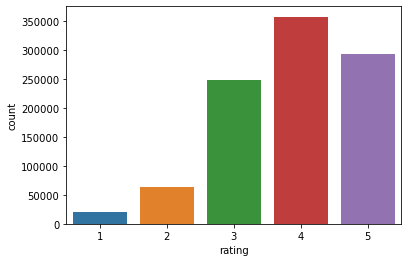

In [5]:
sns.countplot(x='rating', data=ratings);

In [6]:
avg_user_n_ratings = ratings.groupby('user_id')['book_id'].agg('count').median()
avg_book_n_ratings = ratings.groupby('book_id')['user_id'].agg('count').median()

print('Average number of user ratings: ', avg_user_n_ratings)
print('Average number of book ratings: ', avg_book_n_ratings)

Average number of user ratings:  8.0
Average number of book ratings:  100.0


In [7]:
# Make a pivot table for user and books.
pivot = ratings.pivot_table(index=['user_id'], columns=['book_id'], values='rating')
pivot.shape

(53424, 10000)

In [8]:
# Ratings have to be normalized because different books have different average ratings.
pivot_normalized = pivot.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)), axis=1)

In [9]:
# It will be better to remove users who didn't rate books because they don't affect on recommendations.
pivot_normalized.fillna(0, inplace=True)
pivot_normalized = pivot_normalized.T
pivot_normalized = pivot_normalized.loc[:, (pivot_normalized != 0).any(axis=0)]

pivot_normalized.shape

(10000, 47018)

In [10]:
# Take only 10k user ratings in reason of speeding up.
pivot_normalized = pivot_normalized.iloc[:, :10000]

In [11]:
# Replace zeros to nan for correct saving sparse vectors.
pivot_normalized = pivot_normalized.replace(0, np.nan)
pivot_normalized = pivot_normalized.astype('float16')

In [12]:
# Take 10 rows for testing.
test_rows = pivot_normalized.sample(10)
test_rows.head()

user_id,1,2,4,5,6,7,8,9,10,11,...,10941,10942,10943,10944,10945,10946,10947,10948,10949,10950
book_id,,,,,,,,,,,,,,,,,,,,,
5393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Other rows will be used to create a space.
main_part = pivot_normalized[~pivot_normalized.index.isin(test_rows.index)]

In [14]:
# Save the data to sparce vectors file.
main_part.to_csv(join(path_to_spacehosting_data, 'sparse-vectors-df.csv'), header=False, index=False)

In [15]:
# Save metadata.
def write_metadata(meta, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)

meta_df = books_meta[['id', 'authors', 'original_title']]

test_info = meta_df[meta_df.id.isin(test_rows.index)]
meta_df = meta_df[~meta_df.id.isin(test_rows.index)]

metadata = []
for vector in meta_df.to_dict(orient='records'):
    metadata.append(vector)

write_metadata(metadata, join(path_to_spacehosting_data, 'vectors-metadata.json'))

In [16]:
test_info

,id,authors,original_title
1332,1333,Walter Isaacson,Benjamin Franklin: An American Life
2489,2490,"Geoffrey Crayon, Washington Irving, William L....","The Sketch Book of Geoffrey Crayon, Gent"
3949,3950,Jordan Belfort,The Wolf of Wall Street
4617,4618,David Baldacci,Hell's Corner
4802,4803,Brad Stone,
5392,5393,Veronica Roth,Four: The Initiate
5753,5754,"Jorge Luis Borges, Andrew Hurley",Cuentos completos
7496,7497,Jennifer Donnelly,The Winter Rose
8942,8943,Glenn Greenwald,"No Place to Hide: Edward Snowden, the NSA, and..."
9422,9423,Sarra Manning,


# SpaceHosting test

## Setup 

First of all you should open `docker-compose.yaml` in SpaceHosting directory and change two lines (algorithm’s and vector’s file names) as shown below:  
1. `- SH_INDEX_ALGORITHM=SparnnIndex.Cosine`
2. `- SH_VECTORS_FILE_NAME=/data/sparse-vectors-df.csv`

And then restart container with `./docker-compose-up.sh` command from console.

## Testing

In [17]:
# Prepare body and headers for request.
headers = {"Content-Type": "application/json"}

# k is a number of the nearest items for searching for each item in a query.
body = {
  "k": "3"
}

In [18]:
# Make vector dictionary.
vectors = []

for row in test_rows.iterrows():
    indexes, values = [], []
    
    # Find all not empty values in a row for vector. 
    for index, value in enumerate(row[1]):
        if value > 0:
            indexes.append(index)
            values.append(value)
    vectors.append({
        "isSparse": True,
        "dimension": test_rows.shape[1],
        "coordinates": values,
        "coordinateIndices": indexes
    })
    
print(vectors)

[{'isSparse': True, 'dimension': 10000, 'coordinates': [0.1904296875, 0.045440673828125, 0.0128173828125, 0.130126953125, 0.125], 'coordinateIndices': [2342, 5212, 7023, 7652, 9522]}, {'isSparse': True, 'dimension': 10000, 'coordinates': [0.56591796875, 0.5, 0.040008544921875, 0.5, 0.125, 0.396484375], 'coordinateIndices': [1341, 2709, 3137, 3828, 4798, 9882]}, {'isSparse': True, 'dimension': 10000, 'coordinates': [0.55322265625, 0.28564453125, 0.291748046875, 0.07501220703125, 0.10784912109375, 0.041656494140625, 0.35009765625, 0.0196075439453125, 0.221923828125, 0.413818359375, 0.2568359375, 0.0028400421142578125, 0.290283203125, 0.0433349609375], 'coordinateIndices': [1839, 2082, 2422, 2683, 4085, 4996, 5830, 5893, 6111, 6370, 7599, 7963, 8107, 8946]}, {'isSparse': True, 'dimension': 10000, 'coordinates': [0.0333251953125, 0.174560546875, 0.2076416015625, 0.06927490234375, 0.328125], 'coordinateIndices': [2978, 3055, 7487, 7907, 8570]}, {'isSparse': True, 'dimension': 10000, 'coordi

In [19]:
# Add vectors into the body of request.
body["vectors"] = vectors

In [20]:
# Make request to SpaseHosting.
res = requests.post('http://localhost:8080/api/v1/Search', data=json.dumps(body), headers=headers)

In [21]:
# Just look on full info about similar books for the first book from query.
res.json()[0]

[{'distance': 0.605704940453041,
  'vector': {'isSparse': True,
   'dimension': 10000,
   'coordinates': [-0.375,
    0.1904,
    0.04544,
    -0.04877,
    0.01282,
    -0.4722,
    0.1301,
    -0.0804,
    -0.11584,
    0.125],
   'coordinateIndices': [1829,
    2342,
    5212,
    7021,
    7023,
    7404,
    7652,
    8254,
    9264,
    9522]},
  'data': {'id': 5393,
   'authors': 'Veronica Roth',
   'original_title': 'Four: The Initiate'}},
 {'distance': 0.7457501725470113,
  'vector': {'isSparse': True,
   'dimension': 10000,
   'coordinates': [-0.0375,
    -0.5166,
    0.1904,
    -0.1875,
    0.2106,
    -0.04877,
    0.3462,
    0.1301,
    0.1837,
    0.1492,
    0.00595,
    0.361,
    -0.11584],
   'coordinateIndices': [1113,
    1917,
    2342,
    2737,
    6835,
    7021,
    7023,
    7652,
    8264,
    8337,
    8596,
    8791,
    9264]},
  'data': {'id': 2457,
   'authors': 'Veronica Roth',
   'original_title': 'Four: The Transfer'}},
 {'distance': 0.7978369461589

In [22]:
# Print info about similar books.
for index, info in enumerate(test_info.iterrows()):
    id, authors, original_title = info[1]
    print(f'For book \'{original_title}\' written by {authors} with id = {id} the most similar books by user reviews are:')
    
    for i in res.json()[index]:
        dist, book_id, title, authors = i['distance'], i['data']['id'], i['data']['original_title'], i['data']['authors']
        
        print(f'With cosine distance = {dist} book \'{title}\' written by {authors} with id = {book_id}.')
        
    print('-' * 30)

For book 'Benjamin Franklin: An American Life' written by Walter Isaacson with id = 1333 the most similar books by user reviews are:
With cosine distance = 0.605704940453041 book 'Four: The Initiate' written by Veronica Roth with id = 5393.
With cosine distance = 0.7457501725470113 book 'Four: The Transfer' written by Veronica Roth with id = 2457.
With cosine distance = 0.7978369461589946 book 'Män som hatar kvinnor, Flickan som lekte med elden, Luftslottet som sprängdes' written by Stieg Larsson, Reg Keeland with id = 2272.
------------------------------
For book 'The Sketch Book of Geoffrey Crayon, Gent' written by Geoffrey Crayon, Washington Irving, William L. Hedges with id = 2490 the most similar books by user reviews are:
With cosine distance = 0.32404474250071114 book '' written by Brad Stone with id = 4803.
With cosine distance = 0.7832853551481886 book 'Psycho' written by Robert Bloch with id = 2668.
With cosine distance = 0.7959049399447761 book 'Tell Me Your Dreams' written 

### Conclusion

As you can see, not all similar books are really similar. The main reason is reducing the number of users in initial dataset to 10k.